In [15]:
class Sample:

    """
    This class defines and describe the samples from k-seq experiments
    """

    def __init__(self):
        pass

    def import_count_file(self, dirc, sampleType='reacted'):
        """
        :param dirc:
        :param sampleType:
        :return:
        """
        with open(dirc, 'r') as file:
            self.uniqueSeq = int([elem for elem in next(file).strip().split()][-1])
            self.totalSeq = int([elem for elem in next(file).strip().split()][-1])
            next(file)
            self.seqs = {}
            for line in file:
                seq = line.strip().split()
                self.seqs[seq[0]] = int(seq[1])
        self.sampleType = sampleType

    def survey_ext_std(self, stdSeq='AAAAACAAAAACAAAAACAAA', maxDist=10):
        """
        This method will survey the spike in sequences in each sample
        :param stdSeq:
        :return:
        """
        import Levenshtein
        self.stdCounts = np.array([0 for _ in range(maxDist+1)])
        for seq in self.seqs.keys():
            dist = Levenshtein.distance(stdSeq, seq)
            if (dist <= maxDist)and(len(seq)==21):
                self.stdCounts[dist] += self.seqs[seq]

    def get_seq_length(self, minCounts=1, blackList=None):
        if not blackList:
            blackList = []
        return np.array([len(seq[0]) for seq in self.seqs.items() if (seq[0] not in blackList)and(seq[1] >= minCounts)])

    def get_seq_composition(self, fraction=False, minCounts=1, blackList=None):
        if not blackList:
            blackList = []
        seqsNew = np.array([seq[1] for seq in self.seqs.items() if (seq[0] not in blackList)and(seq[1] >= minCounts)])
        if fraction:
            return seqsNew/np.sum(seqsNew)
        else:
            return seqsNew


import sys
import numpy as np
# add package directory to the top of sys.path
if np.sum([dirc.find('k-seq') >= 0 for dirc in sys.path]) == 0:
    sys.path = ['/home/yuning/Work/k-seq/src/'] + sys.path

def basic_info(countFileRoot):
    from os import listdir
    from os.path import isfile, join
    
    def decode_sample_name(sampleName, ex=None):
        import re
        if ("input" in sampleName) or ("Input" in sampleName):
            return {
                'sampleType'
            }
            
        sampleInfo = {}
        
        regex = re.compile(r'-\d+-')
        regex.findall('BYO-100-1_S1_counts.txt')
        

    sampleList = [f for f in listdir(countFileRoot) if isfile(join(countFileRoot, f))]
    sort_fn = lambda s: (int(s.split('_')[1][1:]))
    sampleList.sort(key=sort_fn)
    return countFileRoot, sampleList

 
import util
countFileRoot, sampleList = basic_info(countFileRoot='/mnt/storage/projects/k-seq/input/yc_byo/counts/')
sampleList

['BYO-100-1_S1_counts.txt',
 'BYO-250-3_S2_counts.txt',
 'Input_S3_counts.txt',
 'BYO-0-1_S4_counts.txt',
 'BYO-50-1_S5_counts.txt',
 'BYO-100-3_S6_counts.txt',
 'BYO-500-2_S7_counts.txt',
 'BYO-0-2_S8_counts.txt',
 'BYO-50-2_S9_counts.txt',
 'BYO-250-1_S10_counts.txt',
 'BYO-500-3_S11_counts.txt',
 'BYO-10-1_S12_counts.txt',
 'BYO-50-3_S13_counts.txt',
 'BYO-250-2_S14_counts.txt',
 'BYO-1000-1_S15_counts.txt',
 'BYO-10-2_S16_counts.txt',
 'BYO-10-3_S18_counts.txt',
 'BYO-100-2_S19_counts.txt',
 'BYO-500-1_S20_counts.txt',
 'BYO-1000-3_S21_counts.txt']

# Overview of the sample

In [16]:
def load_all_samples(sampleList, sampleSetDirc=None):
    import util

    if sampleSetDirc:
        sampleSet = util.load_pickle(sampleSetDirc)
    else:
        sampleSet = []
        for sample in sampleList:
            currentSample = Sample()
            currentSample.id = sample[0:sample.find('_counts')]
            if sample.find('input') >= 0:
                currentSample.import_count_file(dirc=countFileRoot+sample, sampleType='input')
                currentSample.survey_ext_std(maxDist=15)
            else:
                currentSample.import_count_file(dirc=countFileRoot+sample, sampleType='reacted')
                currentSample.survey_ext_std(maxDist=15)
            sampleSet.append(currentSample)

    return sampleSet

sampleSet = load_all_samples(sampleList=sampleList)

index,sample name,total counts,unique counts,ext. std. counts,ext. std. percent
1,BYO-100-1_S1,"3,479,648","49,756","1,157,676",0.333
2,BYO-250-3_S2,"4,519,617","12,541","3,689,001",0.816
3,Input_S3,"4,703,135","46,645","3,781,293",0.804
4,BYO-0-1_S4,"4,516,974","18,222","4,442,791",0.984
5,BYO-50-1_S5,"4,415,109","12,858","3,733,744",0.846
6,BYO-100-3_S6,"3,541,789","15,125","2,096,710",0.592
7,BYO-500-2_S7,"3,936,564","37,416","1,254,331",0.319
8,BYO-0-2_S8,"4,602,191","20,318","3,728,172",0.810
9,BYO-50-2_S9,"3,682,399","13,413","2,849,440",0.774
10,BYO-250-1_S10,"4,678,583","19,341","3,065,717",0.655


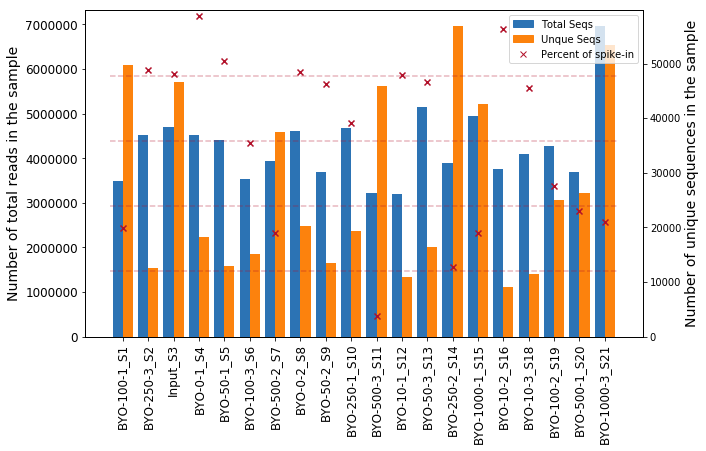

In [22]:
def print_sample_overview(sampleSet, table=False, figures=True, figSaveDirc=None):
    if table:
        from IPython.display import HTML
        tableHTML = """
        <table>
        <tr>
        <th>{}</th>
        <th>{}</th>
        <th>{}</th>
        <th>{}</th>
        <th>{}</th>
        <th>{}</th>
        </tr>
        """.format(
            'index',
            'sample name',
            'total counts',
            'unique counts',
            'ext. std. counts',
            'ext. std. percent'
        )
        for ix,sample in enumerate(sampleSet):
            tableHTML += """
            <tr>
            <td>{}</td>
            <td>{}</td>
            <td>{:,}</td>
            <td>{:,}</td>
            <td>{:,}</td>
            <td>{:.3f}</td>
            </tr>
            """.format(
                ix + 1,
                sample.id,
                sample.totalSeq,
                sample.uniqueSeq,
                sample.stdCounts[0],
                sample.stdCounts[0] / sample.totalSeq
            )
        display(HTML(tableHTML))

    if figures:
        import matplotlib.pyplot as plt
        import matplotlib.patches as mpatch
        import plot

        sampleNum = len(sampleSet)
        fig = plt.figure(figsize=[sampleNum * 0.5, 6])
        # Plot bar for total seqs
        ax = fig.add_subplot(111)
        ax.bar(x=[i - 0.2 for i in range(sampleNum)], height=[sample.totalSeq for sample in sampleSet], align='center',
               width=0.4, color='#2C73B4')
        # plot bar for unique seqs
        ax2 = ax.twinx()
        ax2.bar(x=[i + 0.2 for i in range(sampleNum)], height=[sample.uniqueSeq for sample in sampleSet],
                align='center', width=0.4, color='#FC820D')
        # plot scatter for spike-in percentage
        ax3 = ax.twinx()
        ax3.scatter([i for i in range(sampleNum)], [sample.stdCounts[0] / sample.totalSeq for sample in sampleSet],
                    color='#B2112A', marker='x')
        ax3.plot([-0.5, sampleNum - 0.5], [0.2, 0.2], '#B2112A', ls='--', alpha=0.3)
        ax3.plot([-0.5, sampleNum - 0.5], [0.4, 0.4], '#B2112A', ls='--', alpha=0.3)
        ax3.plot([-0.5, sampleNum - 0.5], [0.6, 0.6], '#B2112A', ls='--', alpha=0.3)
        ax3.plot([-0.5, sampleNum - 0.5], [0.8, 0.8], '#B2112A', ls='--', alpha=0.3)
        ax3.set_ylim([0, 1])
        ax3.set_yticks([])

        # Aesthetic adjustment
        ax.set_ylabel('Number of total reads in the sample', fontsize=14)
        ax2.set_ylabel('Number of unique sequences in the sample', fontsize=14)
        ax.set_xticks([i for i in range(sampleNum)])
        ax.set_xticklabels([sample.id for sample in sampleSet], rotation=90)
        plot.set_ticks_size(ax)
        plot.set_ticks_size(ax2)
        lgd = [mpatch.Patch(color='#2C73B4', label='Total Seqs'), mpatch.Patch(color='#FC820D', label='Unque Seqs'),
               plt.plot([], [], lw=0, marker='x', color='#B2112A', label='Percent of spike-in')[0]]
        plt.legend(handles=lgd)

        if figSaveDirc:
            fig.savefig(figSaveDirc, dpi=300)
        plt.show()



print_sample_overview(sampleSet=sampleSet, table=True, figures=True)

## spike-in

In [ ]:
def plot_std_peak_dist(sampleSet, norm=True, maxDist=15):

    markerList = ['-o', '->', '-+', '-s']  # different marker for different replicates
    colorList = ['#FC820D', '#2C73B4', '#1C7725', '#B2112A', '#70C7C7', '#810080', '#AEAEAE']  # different color for different type of samples
    symbolList = []
    for marker in markerList:
        symbolList += [marker for i in range(7)]

    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=[24, 8])

    for sampleIx, sample in enumerate(sampleSet):
        counts = sample.stdCounts[:maxDist+1]
        countsNormed = counts/counts[0]
        ax[0].plot([i for i in range(maxDist + 1)], countsNormed,
                   symbolList[sampleIx], color=colorList[sampleIx % 7],
                   label=sample.id, alpha=0.5)

    # add binomial distribution guide line
    pList = [0.1, 0.01, 0.001, 0.0005, 0.0001]
    from scipy.stats import binom
    for p in pList:
        rv = binom(21, p)
        pmfs = np.array([rv.pmf(x) for x in range(7)])
        pmfsNormed = pmfs/pmfs[0]
        ax[0].plot([i for i in range(7)], pmfsNormed, color='k', ls = '--', alpha=0.3)
    ax[0].text(s='p=0.1', x=6, y=1e-1, ha='left', va='center', fontsize=12)
    ax[0].text(s='p=0.01', x=6, y=1e-6, ha='left', va='center', fontsize=12)
    ax[0].text(s='p=0.001', x=3.8, y=5e-7, ha='left', va='center', fontsize=12)
    ax[0].text(s='p=0.0001', x=0.8, y=3e-7, ha='left', va='center', fontsize=12)

    ax[0].set_xlabel('Edit distance to spike-in sequence', fontsize=16)
    ax[0].set_yscale('log')
    ax[0].set_ylim([1e-7, 5])
    ax[0].tick_params(labelsize=12)
    ax[0].set_ylabel('Sequence counts\n(normalized on exact spike-in sequence)', fontsize=16)

    for sampleIx, sample in enumerate(sampleSet):
        counts = sample.stdCounts[:maxDist+1]
        countsAccumulated = np.array([np.sum(counts[:i+1]) for i in range(maxDist + 1)])
        countsAccumulatedNormed = countsAccumulated/countsAccumulated[0]
        ax[1].plot([i for i in range(maxDist + 1)], countsAccumulatedNormed,
                   symbolList[sampleIx], color=colorList[sampleIx % 7],
                   label=sample.id, alpha=0.5)
    ax[1].set_xlabel('Edit distance to spike-in sequence', fontsize=16)
    ax[1].tick_params(labelsize=12)
    ax[1].set_ylim([0.8, 1.5])
    ax[1].set_ylabel('Accumulated sequence counts\n(normalized on exact spike-in sequence)', fontsize=16)
    ax[1].legend(loc=[1.02, 0], fontsize=14, frameon=False, ncol=2)
    plt.tight_layout()
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/extStdErr.jpeg', dpi=300)
    plt.show()
